### Chapter 8

### Introduction to Generative Adversarial Networks

Generative adversarial networks (GANs), introduced in 2014 by Goodfellow et al.,
 are
an alternative to VAEs for learning latent spaces of images. They enable the generation
of fairly realistic synthetic images by forcing the generated images to be statistically
almost indistinguishable from real ones.
 
An intuitive way to understand GANs is to imagine a forger trying to create a fake
Picasso painting. At first, the forger is pretty bad at the task. He mixes some of his
fakes with authentic Picassos and shows them all to an art dealer. The art dealer makes
an authenticity assessment for each painting and gives the forger feedback about what
makes a Picasso look like a Picasso. 

The forger goes back to his studio to prepare some
new fakes. As times goes on, the forger becomes increasingly competent at imitating
the style of Picasso, and the art dealer becomes increasingly expert at spotting fakes. In the end, they have on their hands some excellent fake Picassos.
 
 
That’s what a GAN is: a **forger network** and an **expert network**, each being trained
to best the other. As such, a GAN is made of two parts:

* **Generator network**—Takes as input a random vector (a random point in the
latent space), and decodes it into a synthetic image
* **Discriminator network** (or adversary)—Takes as input an image (real or synthetic),
and predicts whether the image came from the training set or was created by
the generator network.

The generator network is trained to be able to fool the discriminator network, and
thus it evolves toward generating increasingly realistic images as training goes on: 
* Artificial images that look indistinguishable from real ones, to the extent that it’s impossible for the discriminator network to tell the two apart (see figure below).

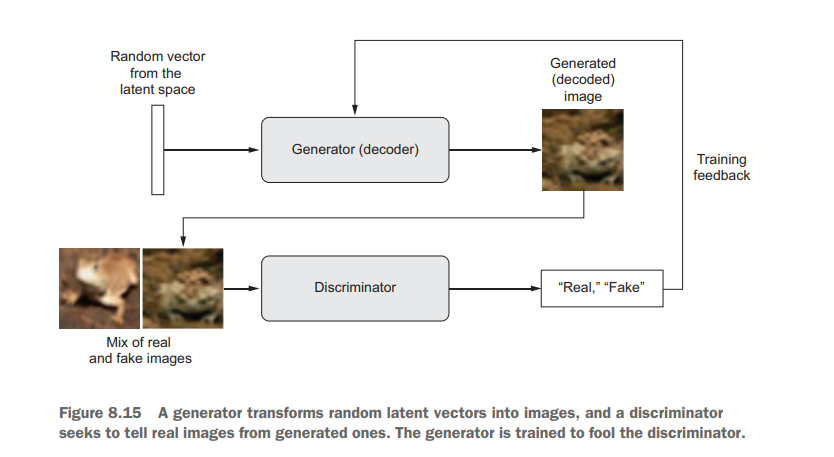

Meanwhile,
the discriminator is constantly adapting to the gradually improving capabilities of the
generator, setting a high bar of realism for the generated images. Once training is
over, the generator is capable of turning any point in its input space into a believable
image. Unlike VAEs, this latent space has fewer explicit guarantees of meaningful
structure; in particular, it isn’t continuous.

Remarkably, a GAN is a system where the optimization minimum isn’t fixed, unlike in
any other training setup we’ve encountered in this book. Normally, gradient descent
consists of rolling down hills in a static loss landscape. But with a GAN, every step
taken down the hill changes the entire landscape a little.

It’s a dynamic system where
the optimization process is seeking not a minimum, but an equilibrium between two
forces. For this reason, GANs are notoriously difficult to train—getting a GAN to work
requires lots of careful tuning of the model architecture and training parameters.

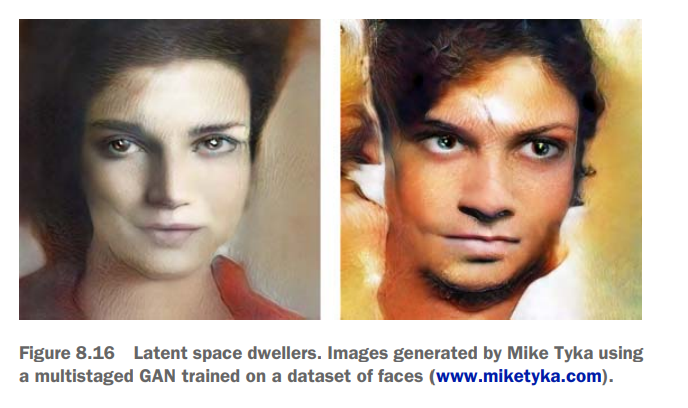

www.miketyka.com

### A schematic GAN implementation

In this section, we’ll explain how to implement a GAN in Keras, in its barest form—
because GANs are advanced, diving deeply into the technical details would be out of
scope. 

The specific implementation is a deep convolutional GAN (DCGAN):
* a GAN where the generator and discriminator are deep convnets. In particular, it uses
a `Conv2DTranspose` layer for image upsampling in the generator.
 
We’ll train the GAN on images from `CIFAR10`, a dataset of `50,000` `32 × 32` RGB
images belonging to `10` classes `(5,000 images per class)`. To make things easier, we’ll
only use images belonging to the class **frog**.
 
Schematically, the GAN looks like this:

1. A generator network maps vectors of shape `(latent_dim,)` to images of shape
`(32, 32, 3)`.
2. A discriminator network maps images of shape `(32, 32, 3)` to a binary score
estimating the probability that the image is real.
3. A gan network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as
decoded by the generator.
4. We train the discriminator using examples of real and fake images along with **real**/**fake** labels, just as we train any regular image-classification model.
5. To train the generator, we use the gradients of the generator’s weights with
regard to the loss of the gan model. This means, at every step, we move the
weights of the generator in a direction that makes the discriminator more likely
to classify as **real** the images decoded by the generator. In other words, we
train the generator to fool the discriminator.

### A bag of tricks

The process of training GANs and tuning GAN implementations is notoriously difficult. There are a number of known tricks we should keep in mind. Like most things
in deep learning, it’s more alchemy than science: 
* These tricks are heuristics, not
theory-backed guidelines. They’re supported by a level of intuitive understanding of
the phenomenon at hand, and they’re known to work well empirically, although not
necessarily in every context.
 
Here are a few of the tricks used in the implementation of the GAN generator and
discriminator. It isn’t an exhaustive list of GAN-related tips; we’ll find
many more across the GAN literature:
* We use `tanh` as the last activation in the generator, instead of `sigmoid`, which is
more commonly found in other types of models.
* We sample points from the latent space using a `normal distribution` (Gaussian distribution), not a uniform distribution
* Stochasticity is good to induce robustness. Because GAN training results in a
dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness
in two ways: 
    * by using dropout in the discriminator and 
    * by adding random noise to the labels for the discriminator.
* Sparse gradients can hinder GAN training. In deep learning, sparsity is often a
desirable property, but not in GANs. Two things can induce gradient sparsity:
    * max pooling operations and 
    * ReLU activations. 
    
  Instead of **max pooling**, we recommend using **strided convolutions** for downsampling, and we recommend
using a `LeakyReLU` layer instead of a `ReLU` activation. It’s similar to `ReLU`, but it
relaxes sparsity constraints by allowing small negative activation values.
* In generated images, it’s common to see checkerboard artifacts caused by
unequal coverage of the pixel space in the generator (see figure below). To fix
this, we use a kernel size that’s divisible by the stride size whenever we use a
strided `Conv2DTranpose` or `Conv2D` in both the generator and the discriminator. 

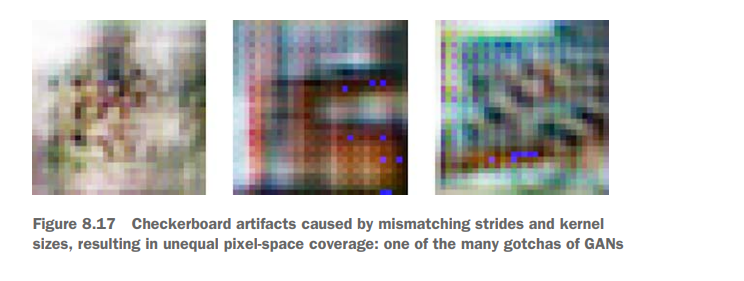

### The generator

First, let’s develop a generator model that turns a vector (from the latent space—
during training it will be sampled at random) into a candidate image. 

One of the
many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise. A possible solution is to use dropout on both the discriminator and the generator.

In [2]:
# GAN generator network

import tensorflow.keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

In [4]:
generator_input = tensorflow.keras.Input(shape=(latent_dim,)) # generator 

In [6]:
# Transforms the input into a 16 × 16 128-channel feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsamples to 32 × 32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produces a 32 × 32 1-channel feature map (shape of a CIFAR10 image)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = tensorflow.keras.models.Model(generator_input, x) # Instantiates the generator model, which maps the input of shape (latent_dim,) into an image of shape (32, 32, 3)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       104883

### The discriminator

Next, we’ll develop a discriminator model that takes as input a candidate image
(real or synthetic) and classifies it into one of two classes: **generated image** or **real
image that comes from the training set**.

In [8]:
# The GAN discriminator network

discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x) # One dropout layer: an important trick!
x = layers.Dense(1, activation='sigmoid')(x) # Classification layer

# Instantiates the discriminator model, which turns a (32, 32, 3) input into a binary classifi-cation decision (fake/real)
discriminator = tensorflow.keras.models.Model(discriminator_input, x)

discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 6, 6, 128)         0   

In [10]:
# Uses gradient clipping (by value) in the optimizer
discriminator_optimizer =tensorflow.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

# To stabilize training, uses learning-rate decay
discriminator.compile(optimizer=discriminator_optimizer,loss='binary_crossentropy')

### The adversarial network

Finally, we’ll set up the GAN, which chains the generator and the discriminator.
When trained, this model will move the generator in a direction that improves its ability to fool the discriminator. This model turns latent-space points into a classification
decision—**fake** or **real**—and it’s meant to be trained with labels that are always
**these are real images**. 

So, training gan will update the weights of generator in a way
that makes discriminator more likely to predict **real** when looking at fake images.

It’s very important to note that we set the discriminator to be frozen during training
(non-trainable): 
* Its weights won’t be updated when training gan. If the discriminator
weights could be updated during this process, then we’d be training the discriminator to always predict **real**, which isn’t what we want!

In [11]:
# Adversarial network

discriminator.trainable = False # Sets discriminator weights to non-trainable (this will only apply to the gan model)

gan_input = tensorflow.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tensorflow.keras.models.Model(gan_input, gan_output)

gan_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### How to train our DCGAN

Now we can begin training. To recapitulate, this is what the training loop looks like
schematically. For each epoch, we do the following:

1. Draw random points in the latent space (random noise).
2. Generate images with generator using this random noise.
3. Mix the generated images with real ones.
4. Train discriminator using these mixed images, with corresponding targets:
either **real** (for the real images) or **fake** (for the generated images).
5. Draw new random points in the latent space.
6. Train gan using these random vectors, with targets that all say **these are real
images**. This updates the weights of the generator (only, because the discriminator is frozen inside gan) to move them toward getting the discriminator to
predict **these are real images** for generated images: this trains the generator
to fool the discriminator.

Let’s implement it.

In [13]:
# Implementing GAN training

import os
from tensorflow.keras.preprocessing import image

(x_train, y_train), (_, _) = tensorflow.keras.datasets.cifar10.load_data() # Loads CIFAR10 data

170500096/170498071 [==============================] - 241s 1us/step


In [14]:
x_train = x_train[y_train.flatten() == 6] # Selects frog images (class 6)

# Normalizes data
x_train = x_train.reshape((x_train.shape[0],) +(height, width, channels)).astype('float32') / 255.

In [15]:
iterations = 10000
batch_size = 20

# Specifies where we want to save generated images
save_dir = 'C:\Waqas Documents\Waqas\W.A\Programming\Data Sciecnce\Deep Learning with Python (Francois Chollet)'

In [16]:
start = 0

for step in range(iterations):
    
    # Samples random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    
    # Decodes them to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    # Combines them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # Assembles labels, discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
    
    # Adds random noise to the labels—an important trick!
    labels += 0.05 * np.random.random(labels.shape)
    
    # Trains the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # Samples random points in the Assembles latent space
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    
    # Assembles labels that say “these are all real images” (it’s a lie!)
    misleading_targets = np.zeros((batch_size, 1))
    
    # Trains the generator (via the gan model, where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors,misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    if step % 100 == 0: # Occasionally saves and plots (every 100 steps)
        gan.save_weights('gan.h5') # Saves model weights
    
        # Prints metrics
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        # Saves one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,'generated_frog' + str(step) + '.png'))
        
        # Saves one real image for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

discriminator loss: 0.6930029392242432
adversarial loss: 0.6854509711265564
discriminator loss: 0.5830874443054199
adversarial loss: 1.5715370178222656
discriminator loss: 0.7157142758369446
adversarial loss: 0.782414436340332
discriminator loss: 0.6993481516838074
adversarial loss: 0.7142245769500732


KeyboardInterrupt: 

When training, we may see the adversarial loss begin to increase considerably, while
the discriminative loss tends to zero—the discriminator may end up dominating the
generator.

If that’s the case, try reducing the discriminator learning rate, and increase
the dropout rate of the discriminator.

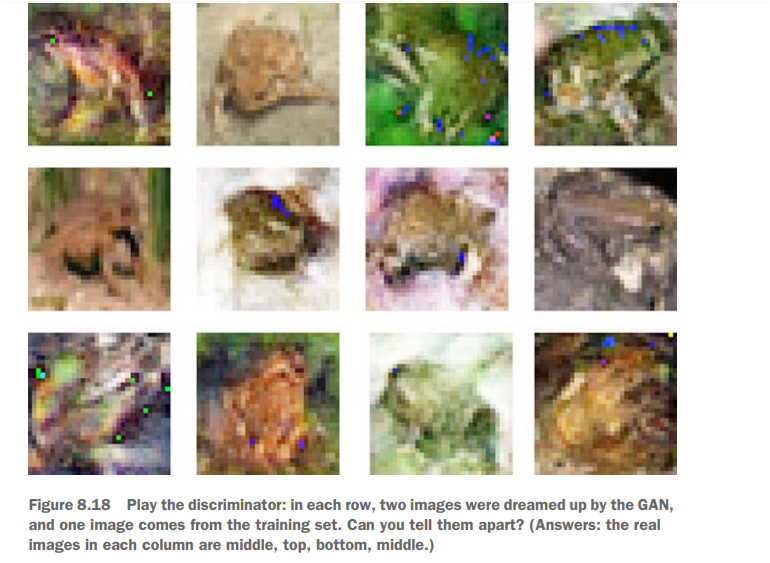

### Conclusion

* A GAN consists of a generator network coupled with a discriminator network.
The discriminator is trained to differenciate between the output of the generator
and real images from a training dataset, and the generator is trained to fool the
discriminator. Remarkably, the generator nevers sees images from the training
set directly; the information it has about the data comes from the discriminator.
* GANs are difficult to train, because training a GAN is a dynamic process rather
than a simple gradient descent process with a fixed loss landscape. Getting a
GAN to train correctly requires using a number of heuristic tricks, as well as
extensive tuning.
* GANs can potentially produce highly realistic images. But unlike VAEs, the
latent space they learn doesn’t have a neat continuous structure and thus may
not be suited for certain practical applications, such as image editing via latentspace concept vectors

### Chapter 8 summary

* With creative applications of deep learning, deep networks go beyond
annotating existing content and start generating their own. We learned
the following:
    * How to generate sequence data, one timestep at a time. This is applicable
    to text generation and also to note-by-note music generation or any other
    type of timeseries data.
    * How DeepDream works: by maximizing convnet layer activations through
    gradient ascent in input space.
    * How to perform style transfer, where a content image and a style image are
    combined to produce interesting-looking results.
    * What GANs and VAEs are, how they can be used to dream up new images,
    and how latent-space concept vectors can be used for image editing.
* These few techniques cover only the basics of this fast-expanding field.
There’s a lot more to discover out there—generative deep learning is
deserving of an entire book of its own. 